## Thalmic Labs Case Study


**Author**: Charley Carriero <br/>
**Date**: 19 June, 2018 <br/>


**The Task**: To identify a user from the motion pattern of their walking activity.
* Prepare a short presentation on your approach and results.
* Outline any business value you think could be created from this / similar data sets.  
* Comment on what kind of additional data points you would like to see to create more value. 

<br/>

In [48]:
## dependencies

import pandas as pd
import numpy as np
import glob
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.pylab import rcParams
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

rcParams['figure.figsize'] = 15,8
%matplotlib inline  

<br/>

## The Data
---

In [2]:
## import data

allFiles = glob.glob('data/*.csv')
frame = pd.DataFrame()
list_ = []

i = 0 
for file in allFiles:
    temp = pd.read_csv(file, header=None)
    temp.columns = ["tstep", "xa", "ya", "za"]
    temp['uid'] =  i 
    list_.append(temp) 
    i = i + 1

frame = pd.concat(list_, ignore_index = True)

In [3]:
# print the first 6 rows 
frame.head() 

,tstep,xa,ya,za,uid
0,0.000000,0.190680,6.5922,6.5514,0
1,0.029480,0.108960,5.8567,6.6604,0
2,0.061523,0.081722,6.7421,8.5808,0
3,0.099396,-1.116900,8.8941,7.0145,0
4,0.129670,0.612920,7.5048,5.6661,0


| Field Definitions |  |
| ------------------| --| 
| tstep | The time step recorded in seconds. Starting from 0. | 
| xa | Acceleration in the x direction | 
| ya | Acceleration in the y direction | 
| za | Acceleration in the z direction | 
| uid | User identification number (0-21)|

## Exploratory Data Analysis (EDA)
---


In [102]:
## how many users are there?
n = len(frame['uid'].unique())
print("Number of users: ", n)

Number of users:  22


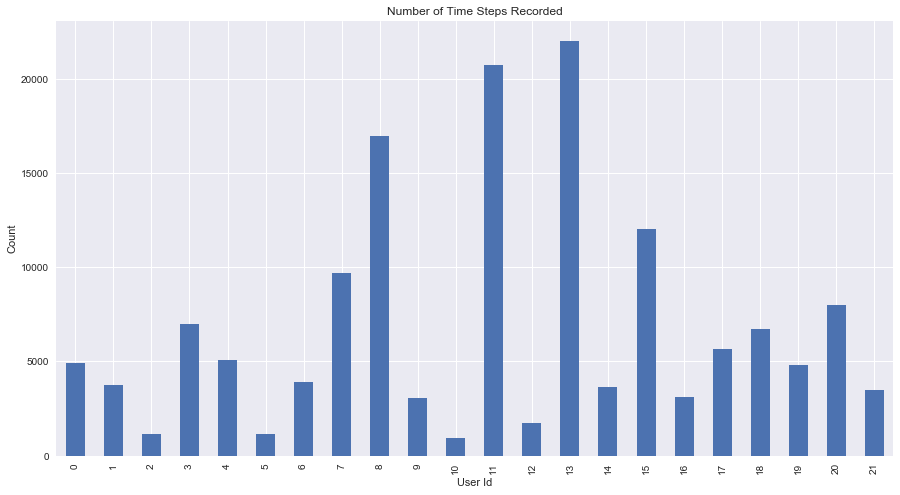

In [7]:
## how many time steps were recorded for each user?
rcParams['figure.figsize'] = 15,8
counts = frame.groupby('uid').size()
counts.plot.bar()
plt.title("Number of Time Steps Recorded")
plt.ylabel("Count")
plt.xlabel("User Id")

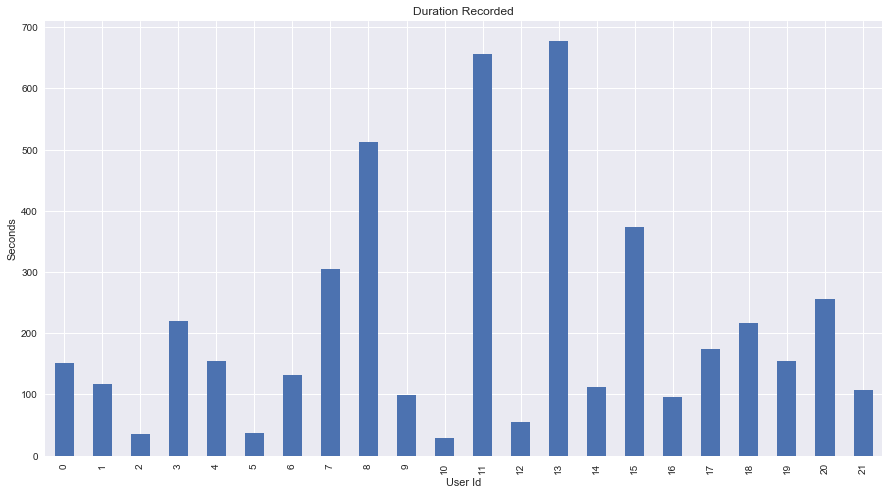

In [8]:
## how long was each participant recorded?
rcParams['figure.figsize'] = 15,8
max_times = frame.groupby("uid").max()["tstep"]
max_times.plot.bar()
plt.title("Duration Recorded")
plt.ylabel("Seconds")
plt.xlabel("User Id")

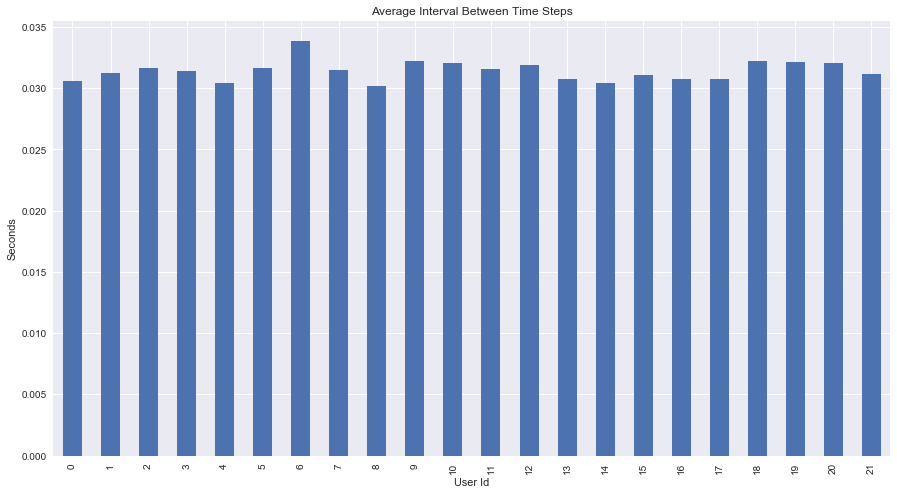

In [10]:
frame["tstep_lag"] = frame.groupby(['uid'])['tstep'].shift(1)
frame["msm_int"] = frame['tstep'] - frame['tstep_lag']
frame.groupby('uid').mean()['msm_int'].plot.bar()
rcParams['figure.figsize'] = 15,8
plt.title("Average Interval Between Time Steps")
plt.ylabel("Seconds")
plt.xlabel("User Id")

In [11]:
def plot_xyz(data, uid):
    '''
    Plot a given users x, y and z acceleration across the given time period
    '''
    user_subset = frame[frame.uid == uid]
    f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True)
    ax1.plot(user_subset['tstep'], user_subset['xa'])
    ax1.set_title('X')
    ax2.plot(user_subset['tstep'], user_subset['ya'])
    ax2.set_title('Y')
    ax3.plot(user_subset['tstep'], user_subset['za'])
    ax3.set_title('Z')
    plt.suptitle('User %d' % uid)
    plt.xlabel('Seconds')
    rcParams['figure.figsize'] = 15,8

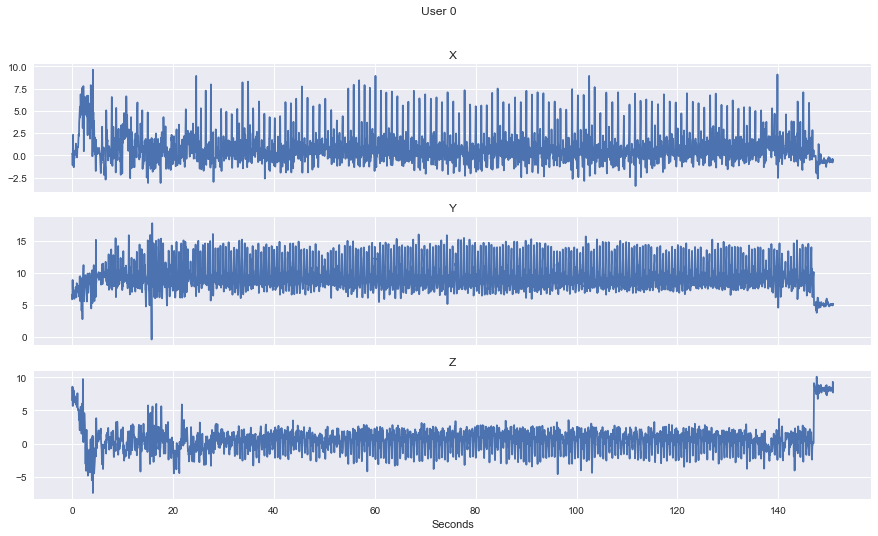

In [12]:
plot_xyz(frame, 0)

- From the above we can see that some users have much less data than others (Users 2,5,10)
- I've decided to keep them in the analysis as they all still have over 1000 observations.
- The recordings were taken across the same average time increment for all the users. This means if we choose to  look at a specific time interval, we will have the same amount of data for each user. 



- As this is sequential time series data the raw accelerometer data needs to be transformed in order to be useful to a classifer. 

## Feature Engineering
---

In [17]:
# calculate resultant vector magnitude 

frame = frame[['tstep', 'xa', 'ya', 'za', 'uid']]                         # drop unnecessary columns

frame['rmag'] = frame.apply(
    lambda row: np.sqrt(row['xa']**2 + row['ya']**2 + row['za']**2),      # calculate
    axis=1
)
frame.head()

,tstep,xa,ya,za,uid,rmag
0,0.000000,0.190680,6.5922,6.5514,0,9.295929
1,0.029480,0.108960,5.8567,6.6604,0,8.869822
2,0.061523,0.081722,6.7421,8.5808,0,10.912961
3,0.099396,-1.116900,8.8941,7.0145,0,11.382253
4,0.129670,0.612920,7.5048,5.6661,0,9.423502


In [26]:
def plot_resultant(data, uid):
    '''
    Plot x,y,z,resultant across time. Share X axis.
    '''
    user_subset = frame[frame.uid == uid].head(500)
    f, (ax1, ax2, ax3, ax4) = plt.subplots(4, sharex=True)
    ax1.plot(user_subset['tstep'], user_subset['xa'])
    ax1.set_title('X acceleration')
    ax2.plot(user_subset['tstep'], user_subset['ya'])
    ax2.set_title('Y acceleration')
    ax3.plot(user_subset['tstep'], user_subset['za'])
    ax3.set_title('Z acceleration')
    ax4.plot(user_subset['tstep'], user_subset['rmag'])
    ax4.set_title('Magnitude of Resultant')
    plt.suptitle('User %d' % uid)
    plt.xlabel('Seconds')
    rcParams['figure.figsize'] = 15,8

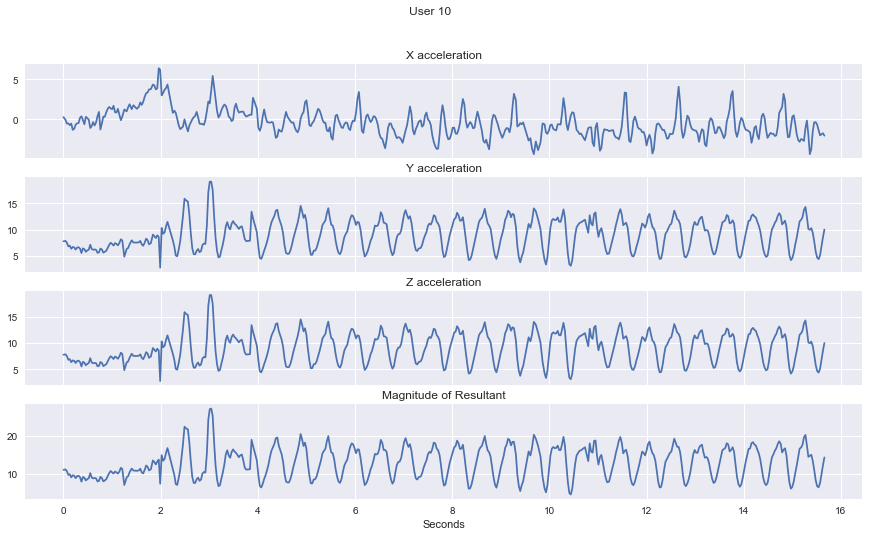

In [28]:
plot_resultant(frame, 10)

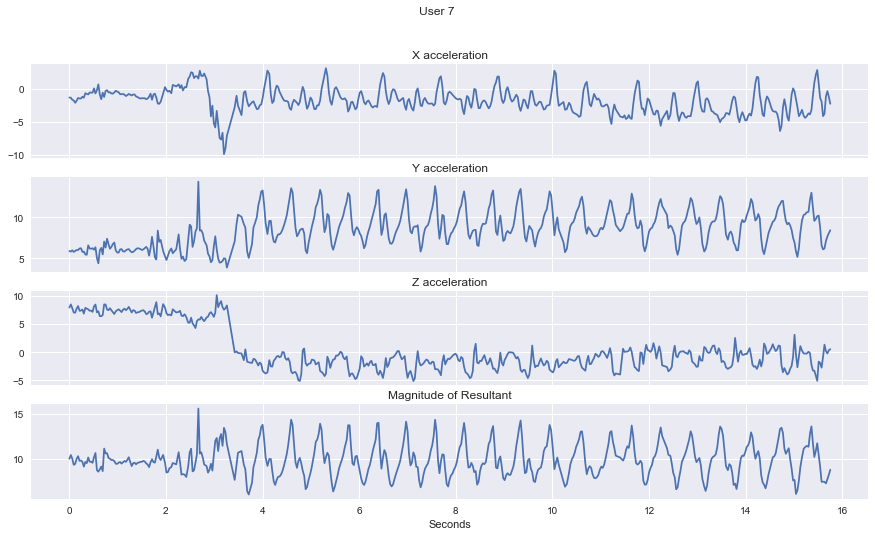

In [30]:
plot_resultant(frame, 7)

In [32]:
# define moving window and data wrangling functions

columns = ['xa','ya','za','rmag']

def get_rolling_window_stats(df, ws):
    '''
    df: input data from one user
    ws: window size
    '''
    a = df.rolling(ws).mean()
    b = df.rolling(ws).std()
    c = df.rolling(ws).max()
    d = df.rolling(ws).min()
    
    a= a.iloc[100::30, :]     # start at 100, keep every 30th row.  
    b= b.iloc[100::30, :]
    c =c.iloc[100::30, :]
    d =d.iloc[100::30, :]

    df_new = pd.concat([a,b,c,d], axis=1)
    return(df_new)

def gen_col_names(col_names):
    '''
    generate column names based on rw stats used
    col_names: parameters used from raw accelerometer data
    '''
    new_names = []
    for col in col_names:
        new_names.append(col + "_mean")
        new_names.append(col + "_std")
        new_names.append(col + "_max")
        new_names.append(col + "_min")
    
    return(new_names)

def gen_user_features(user_df):
    '''
    Generate features for one user
    user_df: subset of data for one specific user
    '''
    
    user_features = pd.DataFrame() 

    for col in columns:                                         
        temp = get_rolling_window_stats(user_df[[col]], 100)
        user_features = pd.concat([user_features, temp], axis = 1)

    user_features.columns = gen_col_names(columns)
    return(user_features)

In [33]:
## generate features

features = pd.DataFrame()
for uid in frame['uid'].unique():                          # for each user (0:21)
    
    u = gen_user_features(frame[frame.uid == uid])         # generate features for that user
    u['uid'] = uid                                         # add a user identification field 
    features = pd.concat([features, u], axis = 0)          # concatinate row-wise to the new features df

features = features.dropna(axis = 0, how = 'any')          # drop any rows with NA values
features.index = range(len(features.index))                # reset the row index

In [34]:
## peek at features 
features.shape

(4914, 17)

<br/>

## Model Selection
---

In [35]:
# generate train and test set
X = features.drop('uid', axis=1)
y = features[['uid']]
print(X.shape)
print(y.shape)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.30)

# reshape y 
ytrain = np.array(ytrain).reshape(ytrain.shape[0],)
ytest = np.array(ytest).reshape(ytest.shape[0],)

(4914, 16)
(4914, 1)


In [36]:
# random forest
rf = RandomForestClassifier()
rf.fit(Xtrain, ytrain)
print("train accuracy:", rf.score(Xtrain,ytrain))
print("test accuracy : ", rf.score(Xtest,ytest))

train accuracy: 0.9985460889793545
test accuracy :  0.8766101694915254


In [37]:
# KNN
knn = KNeighborsClassifier()
knn.fit(Xtrain,ytrain)
print("train accuracy:", knn.score(Xtrain,ytrain))
print("test accuracy :", knn.score(Xtest,ytest))

train accuracy: 0.910729863332364
test accuracy : 0.8366101694915254


In [38]:
# Linear SVM
lin_svm = SVC(kernel = 'linear')
lin_svm.fit(Xtrain,ytrain)
print("train accuracy:", lin_svm.score(Xtrain,ytrain))
print("test accuracy :", lin_svm.score(Xtest,ytest))

train accuracy: 0.8092468740913056
test accuracy : 0.7552542372881356


<br/> 

## Model Assessment 
---

Avenues to further understand model outputs:
* Calculate precision, recall, f1 scores for each user.
* Investigate the confusion matrix. Where are the misclassifications coming from? 